In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix , roc_auc_score, f1_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from category_encoders import BinaryEncoder

In [2]:
import pandas as pd

data = pd.read_csv("human_decision_fatigue_dataset.csv")
data.head()

,Hours_Awake,Decisions_Made,Task_Switches,Avg_Decision_Time_sec,Sleep_Hours_Last_Night,Time_of_Day,Caffeine_Intake_Cups,Stress_Level_1_10,Error_Rate,Cognitive_Load_Score,Decision_Fatigue_Score,Fatigue_Level,System_Recommendation
0,7,28,7,2.30,5.8,Evening,0,2.4,0.000,2.6,15.6,Low,Continue
1,15,77,22,3.65,4.5,Afternoon,3,1.9,0.143,4.5,97.3,High,Take Break
2,11,57,23,3.67,6.8,Night,2,2.1,0.000,4.1,55.4,Moderate,Slow Down
3,8,39,10,2.39,5.3,Afternoon,1,1.0,0.000,2.3,29.7,Low,Continue
4,7,46,16,3.05,8.2,Night,1,2.8,0.000,3.9,19.1,Low,Continue


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hours_Awake             25000 non-null  int64  
 1   Decisions_Made          25000 non-null  int64  
 2   Task_Switches           25000 non-null  int64  
 3   Avg_Decision_Time_sec   25000 non-null  float64
 4   Sleep_Hours_Last_Night  25000 non-null  float64
 5   Time_of_Day             25000 non-null  object 
 6   Caffeine_Intake_Cups    25000 non-null  int64  
 7   Stress_Level_1_10       25000 non-null  float64
 8   Error_Rate              25000 non-null  float64
 9   Cognitive_Load_Score    25000 non-null  float64
 10  Decision_Fatigue_Score  25000 non-null  float64
 11  Fatigue_Level           25000 non-null  object 
 12  System_Recommendation   25000 non-null  object 
dtypes: float64(6), int64(4), object(3)
memory usage: 2.5+ MB


In [4]:
data.isnull().sum()

Hours_Awake               0
Decisions_Made            0
Task_Switches             0
Avg_Decision_Time_sec     0
Sleep_Hours_Last_Night    0
Time_of_Day               0
Caffeine_Intake_Cups      0
Stress_Level_1_10         0
Error_Rate                0
Cognitive_Load_Score      0
Decision_Fatigue_Score    0
Fatigue_Level             0
System_Recommendation     0
dtype: int64

In [5]:
data["Time_of_Day"].unique()
data["Fatigue_Level"].unique()
data["System_Recommendation"].unique()
data["System_Recommendation"] = data["System_Recommendation"].map({"Continue":0,"Take Break":1,"Slow Down":2})
data["Fatigue_Level"] = data["Fatigue_Level"].map({"Low":0, "Moderate":1, "High":2})


<function matplotlib.pyplot.show(close=None, block=None)>

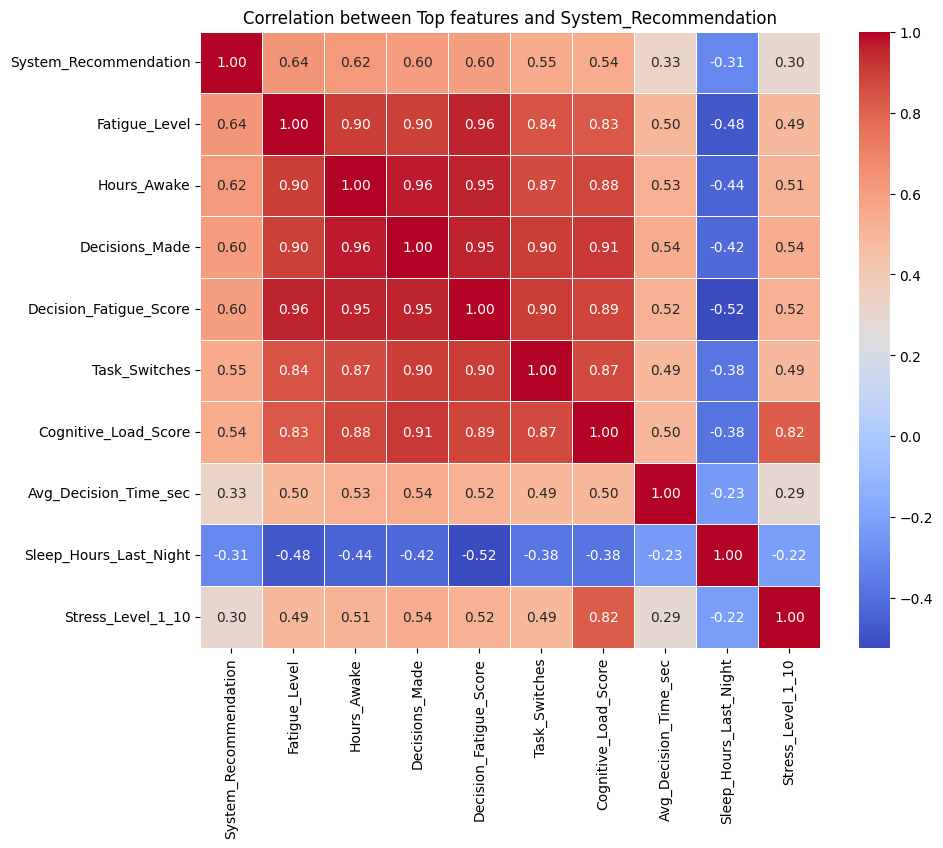

In [6]:
import seaborn as sns
# corr()-Pearson correlation , how two variables move together in a linear way

corr = data.select_dtypes(include=[int,float]).corr()
Top_features = corr["System_Recommendation"].abs().sort_values(ascending=False).index[:10]
plt.figure(figsize=(10,8))
sns.heatmap(corr.loc[Top_features,Top_features], cmap="coolwarm", annot=True, fmt=".2f",linewidths=0.4)
plt.xticks(rotation= 90)
plt.title("Correlation between Top features and System_Recommendation")
plt.show

In [8]:
X = data.drop("System_Recommendation", axis= 1)
y = data["System_Recommendation"]
x_train, x_test, y_train, y_test = train_test_split(X,y , test_size=0.2, stratify=y, random_state=42)

In [9]:
ce = BinaryEncoder(["Time_of_Day"])
x_train = ce.fit_transform(x_train)
x_test = ce.transform(x_test)

In [10]:
d = pd.concat([x_train,y_train],axis=1)
d

,Hours_Awake,Decisions_Made,Task_Switches,Avg_Decision_Time_sec,Sleep_Hours_Last_Night,Time_of_Day_0,Time_of_Day_1,Time_of_Day_2,Caffeine_Intake_Cups,Stress_Level_1_10,Error_Rate,Cognitive_Load_Score,Decision_Fatigue_Score,Fatigue_Level,System_Recommendation
19938,16,77,20,3.18,4.6,0,0,1,4,5.2,0.142,6.4,96.4,2,1
19568,1,6,1,2.13,6.6,0,1,0,0,1.3,0.000,1.0,0.0,0,0
18272,5,26,10,2.20,7.7,0,0,1,3,1.0,0.000,1.9,0.0,0,0
1064,17,88,31,4.14,6.7,0,1,1,2,4.0,0.105,6.6,100.0,2,1
19471,9,43,11,3.78,6.7,0,1,0,1,1.0,0.000,2.4,28.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22144,12,62,19,3.59,7.2,0,1,1,0,4.7,0.000,5.7,58.8,1,2
18972,12,68,18,4.05,7.3,0,1,1,1,2.3,0.000,4.3,58.0,1,2
436,14,75,20,3.41,5.2,0,1,1,2,1.7,0.091,4.3,86.1,2,1
178,9,42,12,2.88,6.7,0,0,1,1,1.3,0.000,2.6,29.3,0,0


<function matplotlib.pyplot.show(close=None, block=None)>

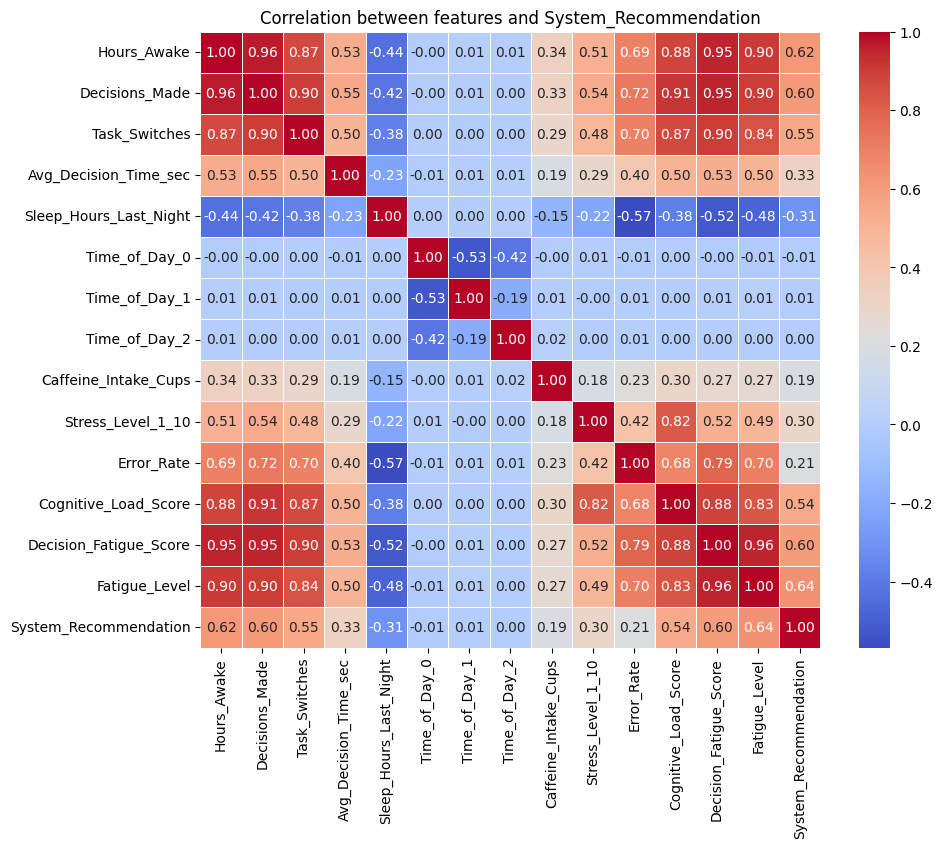

In [11]:
corr = d.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f",linewidths=0.4)
plt.xticks(rotation= 90)
plt.title("Correlation between features and System_Recommendation")
plt.show

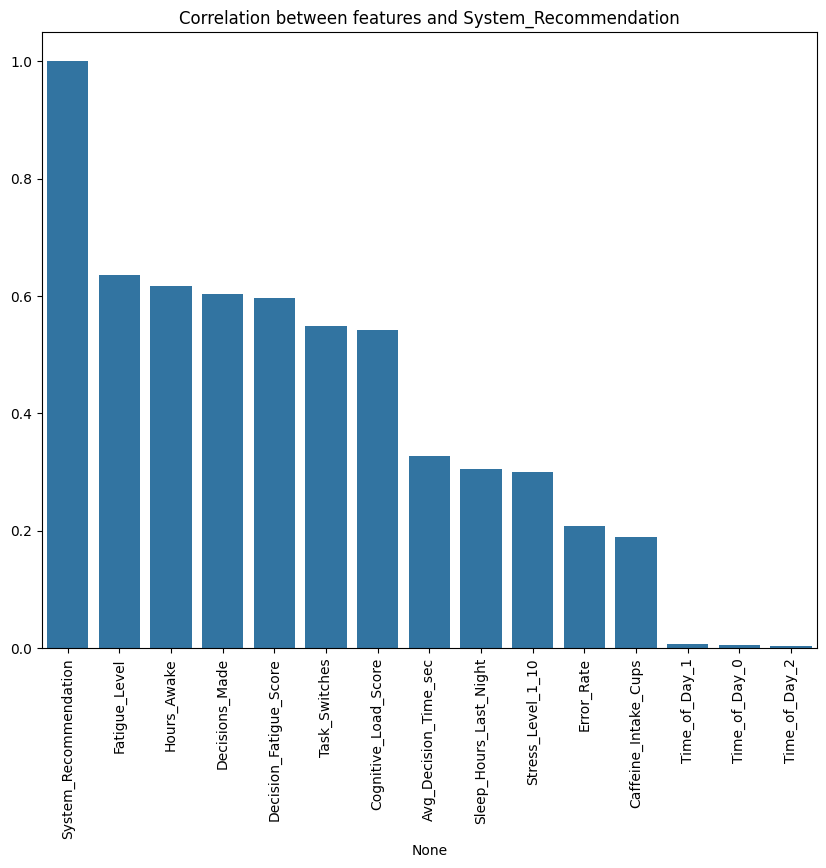

In [12]:
features_idx = corr["System_Recommendation"].abs().sort_values(ascending=False).index[:]
features_values = corr["System_Recommendation"].abs().sort_values(ascending=False).values[:]
plt.figure(figsize=(10,8))
sns.barplot(y= features_values, x= features_idx, data= corr)
plt.xticks(rotation = 90)
plt.title("Correlation between features and System_Recommendation")
plt.show()

In [13]:
x_train = x_train.drop(["Time_of_Day_0","Time_of_Day_1","Time_of_Day_2"], axis=1)
x_test = x_test.drop(["Time_of_Day_0","Time_of_Day_1","Time_of_Day_2"], axis=1)

In [14]:
y.value_counts()

System_Recommendation
0    11728
1     8404
2     4868
Name: count, dtype: int64

In [15]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

In [16]:
acc, auc, f1 = [],[],[]
for i, (train_idx, val_idx) in enumerate(skf.split(x_train,y_train)):
    X_train,x_val = x_train.iloc[train_idx],x_train.iloc[val_idx]
    y_train1,y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    x_val = scaler.transform(x_val)
    classes = y_train1.unique()
    classes_weights = compute_class_weight(classes=classes, class_weight= "balanced", y= y_train1)
    classes_weights_dict = dict(zip(classes,classes_weights))
    sample = compute_sample_weight(class_weight= classes_weights_dict, y= y_train1)
    System_Recommendation_model = XGBClassifier(
                                eval_metric="mlogloss",
                                use_label_encoder=False,
                                n_estimators=100,
                                max_depth=5,
                                learning_rate=0.1
                                )
    System_Recommendation_model.fit(X_train,y_train1, sample_weight = sample)
    pred= System_Recommendation_model.predict(x_val)
    pred_proba = System_Recommendation_model.predict_proba(x_val)
    accuracy = accuracy_score(y_val,pred)
    roc_auc = roc_auc_score(y_val,pred_proba, multi_class="ovr", average="macro")
    f1s = f1_score(y_val,pred, average="macro")
    acc.append(accuracy)
    auc.append(roc_auc)
    f1.append(f1s)
    print(f"Performance at {i}Fold:\nACC:{accuracy}\nAUC:{roc_auc}\nF1_Score:{f1s}")
print(f"Final Performance:\nACC:{np.mean(acc)}\nAUC:{np.mean(auc)}\nF1_Score:{np.mean(f1)}")


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 0Fold:
ACC:1.0
AUC:1.0
F1_Score:1.0
Performance at 1Fold:
ACC:1.0
AUC:1.0
F1_Score:1.0


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 2Fold:
ACC:1.0
AUC:1.0
F1_Score:1.0


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:26:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 3Fold:
ACC:1.0
AUC:1.0
F1_Score:1.0


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:26:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 4Fold:
ACC:0.99975
AUC:0.9996182722925733
F1_Score:0.9996971425525261
Final Performance:
ACC:0.9999499999999999
AUC:0.9999236544585146
F1_Score:0.9999394285105051


In [17]:
x_test = scaler.transform(x_test)
pred = System_Recommendation_model.predict(x_test)
pred_proba = System_Recommendation_model.predict_proba(x_test)
accuracy = accuracy_score(y_test,pred)
roc_auc = roc_auc_score(y_test,pred_proba, multi_class="ovr", average="macro")
f1s = f1_score(y_test,pred, average="macro")

print(f"Performance:\nACC:{accuracy}\nAUC:{roc_auc}\nF1_Score:{f1s}")

Performance:
ACC:1.0
AUC:1.0
F1_Score:1.0


In [18]:
data

,Hours_Awake,Decisions_Made,Task_Switches,Avg_Decision_Time_sec,Sleep_Hours_Last_Night,Time_of_Day,Caffeine_Intake_Cups,Stress_Level_1_10,Error_Rate,Cognitive_Load_Score,Decision_Fatigue_Score,Fatigue_Level,System_Recommendation
0,7,28,7,2.30,5.8,Evening,0,2.4,0.000,2.6,15.6,0,0
1,15,77,22,3.65,4.5,Afternoon,3,1.9,0.143,4.5,97.3,2,1
2,11,57,23,3.67,6.8,Night,2,2.1,0.000,4.1,55.4,1,2
3,8,39,10,2.39,5.3,Afternoon,1,1.0,0.000,2.3,29.7,0,0
4,7,46,16,3.05,8.2,Night,1,2.8,0.000,3.9,19.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,11,47,15,1.90,5.3,Afternoon,1,3.4,0.000,4.2,51.9,1,2
24996,2,13,4,2.44,6.6,Afternoon,1,1.5,0.000,1.5,0.0,0,0
24997,1,2,1,2.12,7.2,Night,1,1.0,0.000,0.7,0.0,0,0
24998,5,28,11,3.49,5.9,Afternoon,1,1.0,0.000,2.0,9.8,0,0


In [19]:
data2 = data.drop(["Time_of_Day","System_Recommendation"], axis=1)
data2["Fatigue_Level"].unique()

array([0, 2, 1])

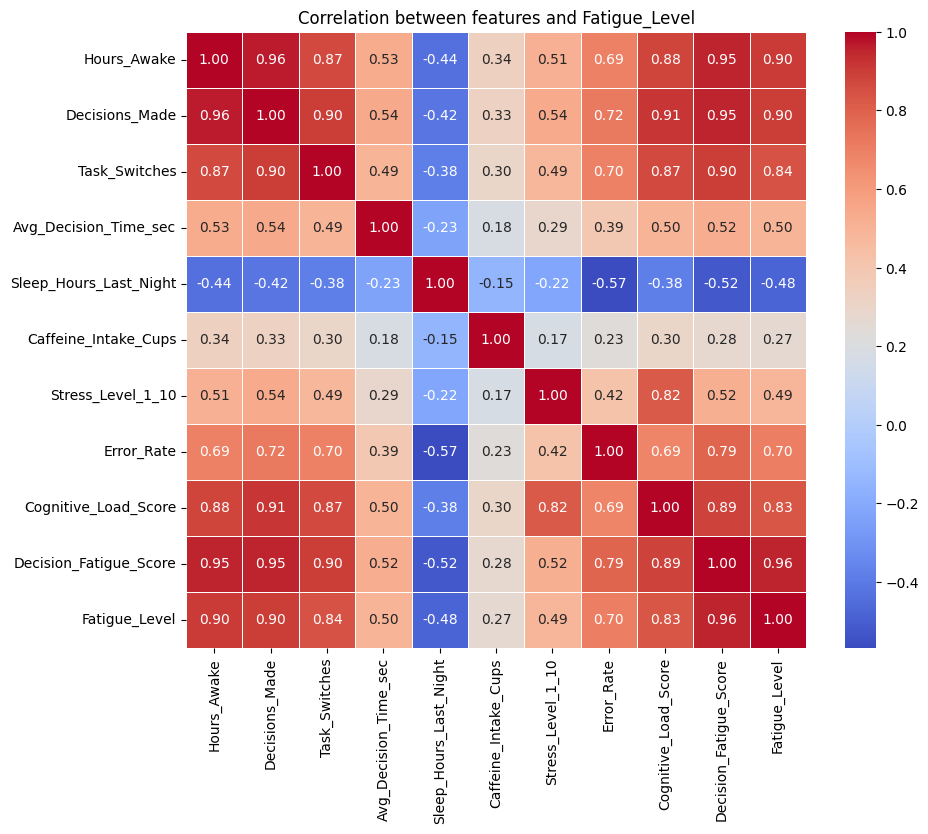

In [20]:
corr = data2.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", fmt=".2f", annot=True, linewidths=0.4)
plt.xticks(rotation=90)
plt.title("Correlation between features and Fatigue_Level")
plt.show()

In [21]:
X = data2.drop("Fatigue_Level", axis=1)
y = data2["Fatigue_Level"]
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [22]:
acc2, auc2, f1_2 = [],[],[]
for i, (train_idx, val_idx) in enumerate(skf.split(x_train,y_train)):
    X_train,x_val = x_train.iloc[train_idx],x_train.iloc[val_idx]
    y_train1,y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    scaler2 = StandardScaler()
    X_train = scaler2.fit_transform(X_train)
    x_val = scaler2.transform(x_val)
    classes = y_train1.unique()
    classes_weights = compute_class_weight(classes=classes, class_weight= "balanced", y= y_train1)
    classes_weights_dict = dict(zip(classes,classes_weights))
    sample = compute_sample_weight(class_weight= classes_weights_dict, y= y_train1)
    Fatigue_Level_model = XGBClassifier(
                                eval_metric="mlogloss",
                                use_label_encoder=False,
                                n_estimators=100,
                                max_depth=5,
                                learning_rate=0.1
                                )
    Fatigue_Level_model.fit(X_train,y_train1, sample_weight = sample)
    pred= Fatigue_Level_model.predict(x_val)
    pred_proba = Fatigue_Level_model.predict_proba(x_val)
    accuracy = accuracy_score(y_val,pred)
    roc_auc = roc_auc_score(y_val,pred_proba, multi_class="ovr", average="macro")
    f1s = f1_score(y_val,pred, average="macro")
    acc2.append(accuracy)
    auc2.append(roc_auc)
    f1_2.append(f1s)
    print(f"Performance at {i}Fold:\nACC:{accuracy}\nAUC:{roc_auc}\nF1_Score:{f1s}")
print(f"Final Performance:\nACC:{np.mean(acc2)}\nAUC:{np.mean(auc2)}\nF1_Score:{np.mean(f1_2)}")

C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:28:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 0Fold:
ACC:0.998
AUC:0.9999847231825306
F1_Score:0.9975078204647362


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:28:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 1Fold:
ACC:1.0
AUC:1.0
F1_Score:1.0


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:28:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 2Fold:
ACC:0.99725
AUC:0.9999949176421433
F1_Score:0.9964893676474341


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:28:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 3Fold:
ACC:0.9985
AUC:0.9999947011560323
F1_Score:0.9981499495841639


C:\Users\ANKITA SINGH\ml_env\lib\site-packages\xgboost\training.py:199: UserWarning: [12:28:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance at 4Fold:
ACC:0.999
AUC:0.9999972450627874
F1_Score:0.998646700878783
Final Performance:
ACC:0.99855
AUC:0.9999943174086987
F1_Score:0.9981587677150235


In [23]:
x_test = scaler2.transform(x_test)
pred = Fatigue_Level_model.predict(x_test)
pred_proba = Fatigue_Level_model.predict_proba(x_test)
accuracy = accuracy_score(y_test,pred)
roc_auc = roc_auc_score(y_test,pred_proba, multi_class="ovr", average="macro")
f1s = f1_score(y_test,pred, average="macro")

In [24]:
print(f"Performance:\nACC:{accuracy}\nAUC:{roc_auc}\nF1_Score:{f1s}")

Performance:
ACC:0.9986
AUC:0.9999959909764375
F1_Score:0.9981358712952232


In [25]:
def predicting_Fatigue_Level_System_Recommendation(df):
    df_copy = df.copy()
    df_copy = pd.DataFrame(df_copy)
    df_scaled = scaler2.transform(df_copy)
    Fatigue_Level = Fatigue_Level_model.predict(df_scaled)
    df_copy["Fatigue_Level"] = Fatigue_Level
    System_Recommendation = System_Recommendation_model.predict(df_copy)
    df_copy["System_Recommendation"] = System_Recommendation
    df_copy["Fatigue_Level"] = df_copy["Fatigue_Level"].map({0:"Low", 1:"Moderate", 2:"High"})
    df_copy["System_Recommendation"] = df_copy["System_Recommendation"].map({0:"Continue",1:"Take Break",2:"Slow Down"})
    print(f"Your Fatigue Level is: {df_copy['Fatigue_Level'].iloc[0]}\nWe recommend you to: {df_copy['System_Recommendation'].iloc[0]}")
    return df_copy

new_data = [{
        "Hours_Awake": 8,
        "Decisions_Made": 120,
        "Task_Switches": 15,
        "Avg_Decision_Time_sec": 3.2,
        "Sleep_Hours_Last_Night": 6,
        "Caffeine_Intake_Cups": 2,
        "Stress_Level_1_10": 7,
        "Error_Rate": 0.05,
        "Cognitive_Load_Score": 65,
        "Decision_Fatigue_Score": 40,
    }]


result = predicting_Fatigue_Level_System_Recommendation(new_data)
result

Your Fatigue Level is: Moderate
We recommend you to: Slow Down


,Hours_Awake,Decisions_Made,Task_Switches,Avg_Decision_Time_sec,Sleep_Hours_Last_Night,Caffeine_Intake_Cups,Stress_Level_1_10,Error_Rate,Cognitive_Load_Score,Decision_Fatigue_Score,Fatigue_Level,System_Recommendation
0,8,120,15,3.2,6,2,7,0.05,65,40,Moderate,Slow Down
